In [2]:
from cmdstanpy import CmdStanModel 
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import stan

/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [634]:
data = pd.read_csv('./cars.csv')
data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900
5,5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Warszawa,Mazowieckie,51900
6,6,opel,combo,gen-d-2011,2017,119965,1248,Diesel,Wrocław,Dolnośląskie,44700
7,7,opel,combo,gen-d-2011,2016,201658,1248,Diesel,Lublin,Lubelskie,29000
8,8,opel,combo,gen-d-2011,2014,178666,1598,Diesel,Złotów,Wielkopolskie,28900
9,9,opel,combo,gen-d-2011,2015,113000,1248,Diesel,Strzyżew,Mazowieckie,34900


In [635]:
print(data.mark.unique())

['opel' 'audi' 'bmw' 'volkswagen' 'ford' 'mercedes-benz' 'renault'
 'toyota' 'skoda' 'alfa-romeo' 'chevrolet' 'citroen' 'fiat' 'honda'
 'hyundai' 'kia' 'mazda' 'mini' 'mitsubishi' 'nissan' 'peugeot' 'seat'
 'volvo']


In [636]:
# data = data.loc[(data['mark'] == 'mazda') | (data['mark'] == 'toyota') | (data['mark'] == 'nissan') ]
data = data.loc[(data['mark'] == 'opel')]
# data = data.loc[(data['mark']=='volvo')]
data


,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900
...,...,...,...,...,...,...,...,...,...,...,...
12453,12453,opel,zafira,gen-c-2011,2012,203000,1956,Diesel,Kołobrzeg,Zachodniopomorskie,27900
12454,12454,opel,zafira,gen-c-2011,2013,187600,1956,Diesel,Wrocław,Dolnośląskie,42000
12455,12455,opel,zafira,gen-c-2011,2016,145000,1598,Diesel,Busko-Zdrój,Świętokrzyskie,46500
12456,12456,opel,zafira,gen-c-2011,2012,80000,1796,Gasoline,Zamość,Lubelskie,30400


In [728]:
# Standarizing mileage, vol_engine and year
# mileage
mean_mileage = data.mileage.mean()
std_mileage = data.mileage.std()

data['c_mileage'] = data.mileage - mean_mileage
data['s_mileage'] = (data.mileage - mean_mileage)/std_mileage

# vol_engine
mean_vol_engine = data.vol_engine.mean()
std_vol_engine = data.vol_engine.std()
data['c_vol_engine'] = data.vol_engine - mean_vol_engine
data['s_vol_engine'] = (data.vol_engine - mean_vol_engine)/std_vol_engine

# year
mean_year = data.year.mean()
std_year = data.year.std()
data['c_year'] = data.year - mean_year
data['s_year'] = (data.year - mean_year)/std_year

mean_price = data.price.mean()
std_price = data.price.std()
data['s_price'] = (data.price - mean_price)/std_price
data.head(10)


,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,c_mileage,s_mileage,c_vol_engine,s_vol_engine,c_year,s_year,s_price,c_vol_engine2,c_vol_engine3
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900,-14980.311398,-0.190338,-351.194141,-1.074924,3.331711,0.644302,0.027795,123337.324916,-4.331535e+07
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501,-122557.311398,-1.557194,-100.194141,-0.306671,6.331711,1.224457,1.525978,10038.865960,-1.005836e+06
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000,123888.688602,1.574111,-1.194141,-0.003655,3.331711,0.644302,-0.285198,1.425974,-1.702814e+00
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800,-106948.311398,-1.358869,-351.194141,-1.074924,4.331711,0.837687,-0.151561,123337.324916,-4.331535e+07
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900,-51548.311398,-0.654965,-199.194141,-0.609687,2.331711,0.450917,0.027795,39678.305947,-7.903686e+06
5,5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Warszawa,Mazowieckie,51900,-33345.311398,-0.423680,-1.194141,-0.003655,5.331711,1.031072,0.590480,1.425974,-1.702814e+00
6,6,opel,combo,gen-d-2011,2017,119965,1248,Diesel,Wrocław,Dolnośląskie,44700,-34583.311398,-0.439410,-351.194141,-1.074924,5.331711,1.031072,0.337272,123337.324916,-4.331535e+07
7,7,opel,combo,gen-d-2011,2016,201658,1248,Diesel,Lublin,Lubelskie,29000,47109.688602,0.598568,-351.194141,-1.074924,4.331711,0.837687,-0.214863,123337.324916,-4.331535e+07
8,8,opel,combo,gen-d-2011,2014,178666,1598,Diesel,Złotów,Wielkopolskie,28900,24117.688602,0.306436,-1.194141,-0.003655,2.331711,0.450917,-0.218380,1.425974,-1.702814e+00
9,9,opel,combo,gen-d-2011,2015,113000,1248,Diesel,Strzyżew,Mazowieckie,34900,-41548.311398,-0.527906,-351.194141,-1.074924,3.331711,0.644302,-0.007373,123337.324916,-4.331535e+07


In [642]:
def is_sorted(a):
    '''Check if numpy 1d-array is sorted '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a))) 
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape)) 
    return np.all(a[:-1] <= a[1:])

In [643]:
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"


In [644]:
def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x), type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0) 
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

In [645]:
def get_quantiles(fx, probs=None): 
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90] 
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even') 
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)') 
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2)))) 
    return np.percentile(fx, probs, axis=0)

In [646]:
def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x). x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca() 
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx) 
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]
    
    for i in range(int(nq/2)): ax.fill_between(x,
                            perc_interv[i,:],
                            perc_interv[-(i+1),:],
                            color=colortab[i],
                            zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder) 
    return ax

In [725]:
print("Standard diviation of mileage:",data.mileage.std())
print("Mean of mileage:",data.s_mileage.mean())
print("Standard diviation of price:",data.price.std())
print("Mean of price:",data.price.mean())
print("Minimal value of price:",data.s_price.min())
print("Maximal value of price:",data.s_price.max())
print("Maximal value of year:",data.s_year.max())

Standard diviation of mileage: 78703.92396905727
Mean of mileage: -5.725373731154072e-17
Standard diviation of price: 28435.104304077184
Mean of price: 35109.64764143025
Minimal value of price: -1.1749437344824436
Maximal value of price: 33.93303369104289
Maximal value of year: 1.9979960527846166


Centered car mileage min:  -154548.31139835488
Centered car mileage max:  538251.6886016452


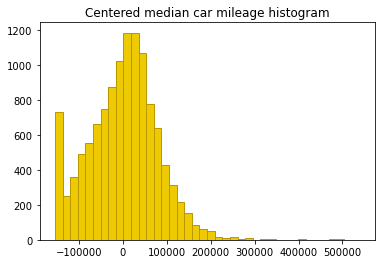

In [648]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(data.c_mileage, bins = 40, color = DARK, edgecolor = DARK_HIGHLIGHT)
axes.set_title("Centered median car mileage histogram")
plt.plot()
print("Centered car mileage min: ", data.c_mileage.min())
print("Centered car mileage max: ", data.c_mileage.max())

Text(0.5, 1.0, 'Price histogram')

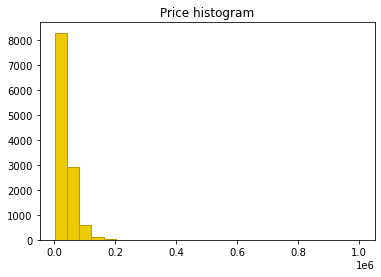

In [649]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(data.price, bins = 25, color = DARK, edgecolor = DARK_HIGHLIGHT)
axes.set_title("Price histogram")

[]

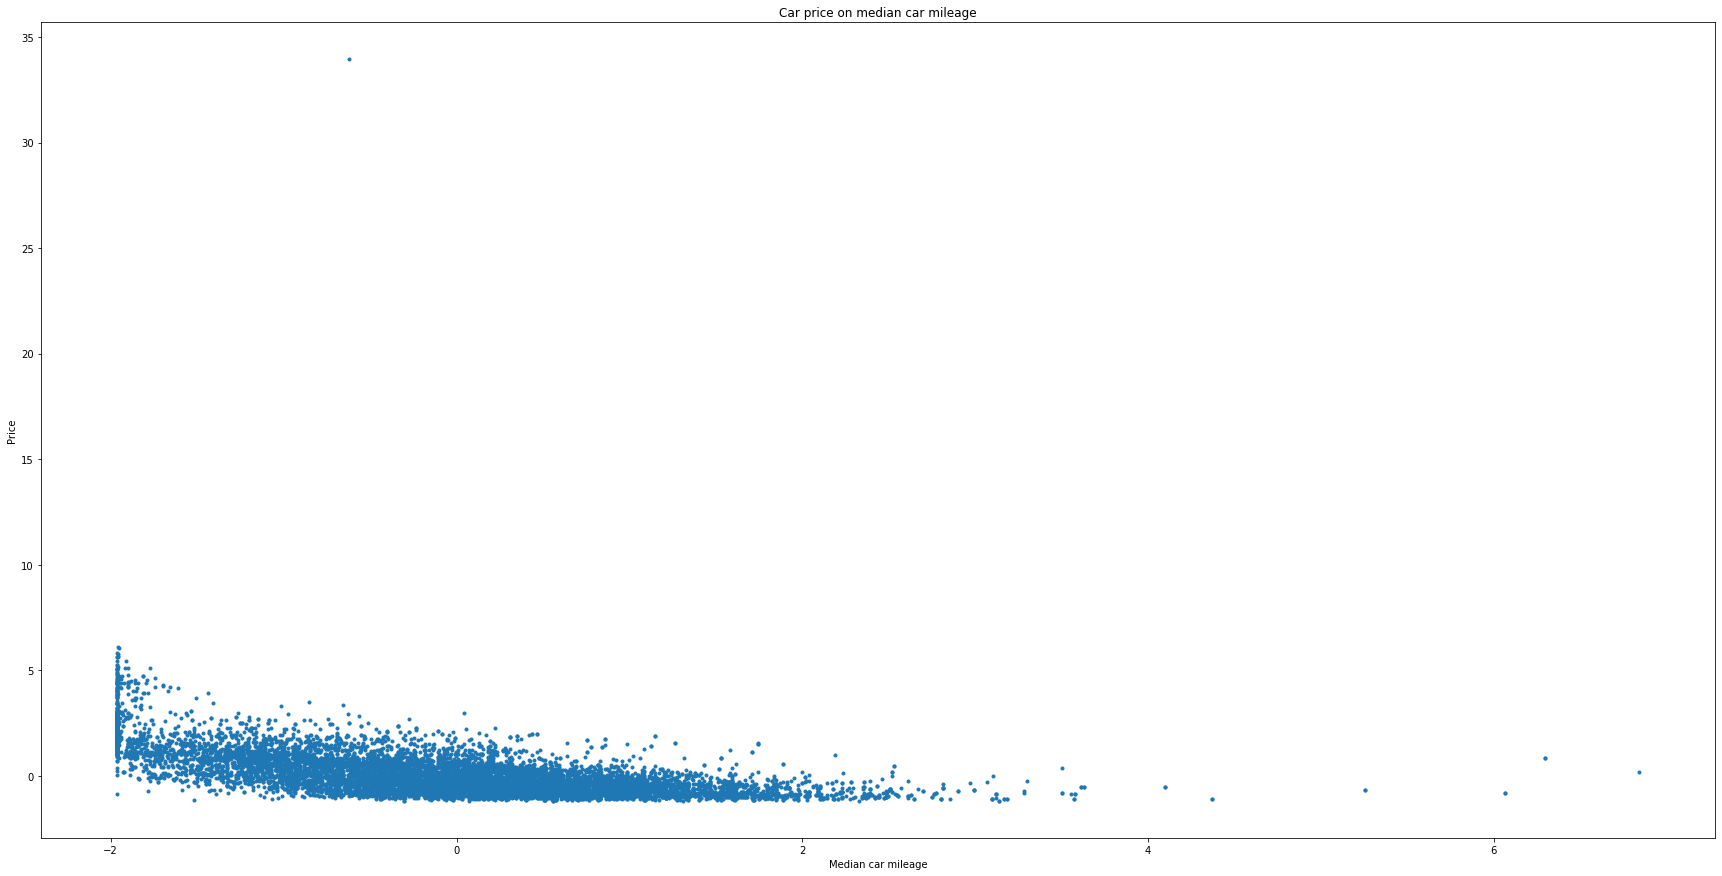

In [650]:
fig, axes = plt.subplots(1, 1, figsize=(30, 15))
plt.plot(data.s_mileage, data.s_price, 'o', markersize=3)
axes.set_xlabel("Median car mileage")
axes.set_ylabel("Price")
axes.set_title("Car price on median car mileage")
plt.plot()

In [719]:
with open('cost_ppc.stan', 'r') as file: 
    print(file.read())

data { int N;
       real mileage[N];
}
generated quantities {
            real alpha = normal_rng(0,1);
            real beta = normal_rng(0,1);
            real sigma = exponential_rng(0.01);
            real price[N];
            for (i in 1:N) {
              price[i] = normal_rng(mileage[i]*beta+alpha,sigma);
            }
}



In [729]:
model_ppc=CmdStanModel(stan_file='cost_ppc.stan')
R = 1000
data_sim={'N': 50, 'mileage': np.linspace(data.s_mileage.min(),data.s_mileage.max())}
sim=model_ppc.sample(data=data_sim,
                        iter_sampling=R, 
                        iter_warmup=0, 
                        chains=1,
                        fixed_param=True, 
                        seed=29042020)

alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |█████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


[]

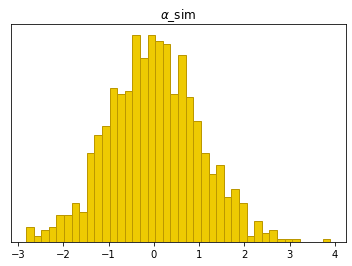

In [730]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(alpha_sim, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\alpha$_sim')
ax.set_yticks(())

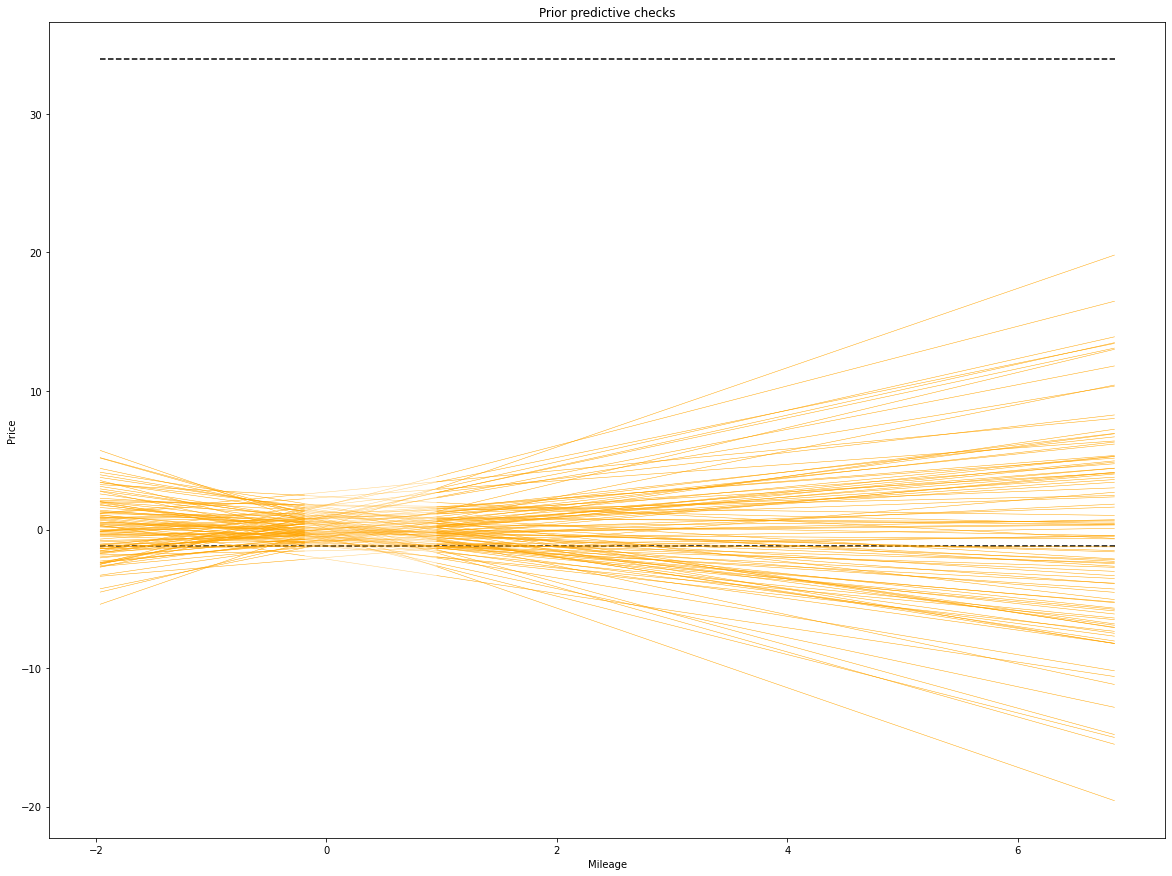

In [733]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.hlines([data.s_price.min(), data.s_price.max()], xmin=data.s_mileage.min(),xmax=data.s_mileage.max(),linestyle='--',color='black')

for i in range(100):
    axes.plot(data.s_mileage, alpha_sim[i]+beta_sim[i]*data.s_mileage,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title(r'Prior predictive checks')
axes.annotate(text='4mln PLN', xy=(10000,4100000))
plt.show()

Model u gory nie ma sensu, duzo hajsu jest ponizej 0 co nijak przeklada sie na rzeczywistosc, trzbea zmienic funckje dystrybucji z normal na lognormal

In [734]:
with open('cost_ppc_improved.stan', 'r') as file: 
    print(file.read())

data { int N;
       real mileage[N];
}
generated quantities {
            real alpha = normal_rng(0,1);
            real beta = lognormal_rng(0,1);
            real sigma = exponential_rng(0.001); # variable that provide better ribbon plot
            real price[N];
            for (i in 1:N) {
              price[i] = normal_rng(mileage[i]*beta+alpha,sigma);
            }
}




In [735]:
model_ppc=CmdStanModel(stan_file='cost_ppc_improved.stan')
R = 1000
data_sim={'N': 50, 'mileage': np.linspace(data.s_mileage.min(),data.s_mileage.max())}
sim=model_ppc.sample(data=data_sim,
                        iter_sampling=R, 
                        iter_warmup=0, 
                        chains=1,
                        fixed_param=True, 
                        seed=29042020)

alpha_sim_improved=sim.stan_variable('alpha')
beta_sim_improved=sim.stan_variable('beta')

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved.stan to exe file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved.hpp /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved.stan
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved.stan', line 2, column 7: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_ppc_improved.stan', line


INFO:cmdstanpy:CmdStan done processing.


[]

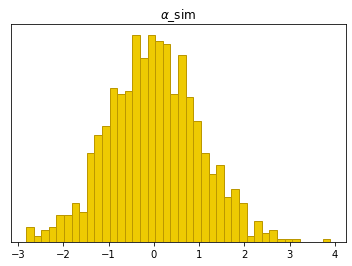

In [736]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(alpha_sim_improved, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\alpha$_sim')
ax.set_yticks(())

[]

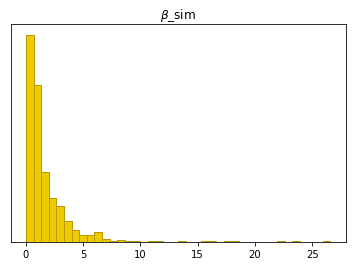

In [737]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(beta_sim_improved, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\beta$_sim')
ax.set_yticks(())

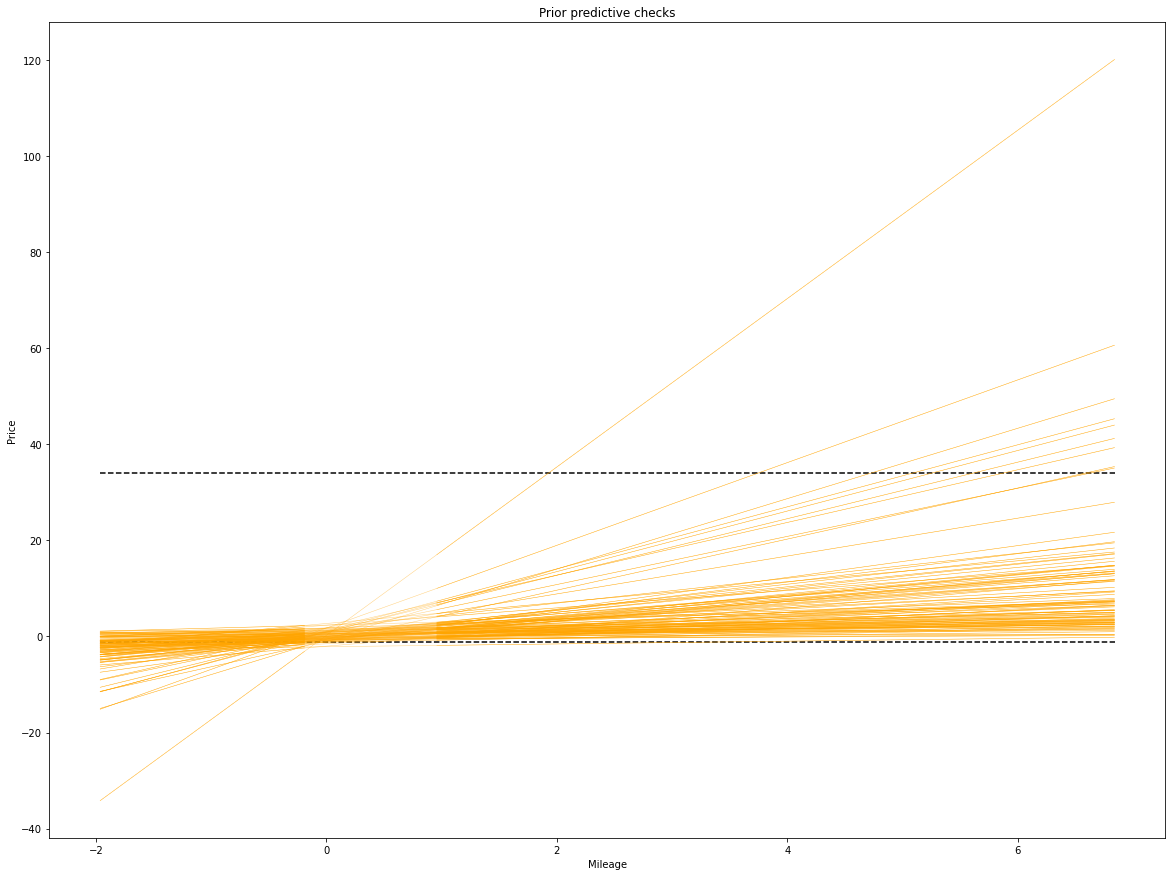

In [738]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.hlines([data.s_price.min(), data.s_price.max()], xmin=data.s_mileage.min(),xmax=data.s_mileage.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.s_mileage, alpha_sim_improved[i]+beta_sim_improved[i]*data.s_mileage,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title(r'Prior predictive checks')
axes.annotate(text='2mln PLN', xy=(10000,2100000))
plt.show()

O WIELE LEPIEJ TO WYGLADA JUZ

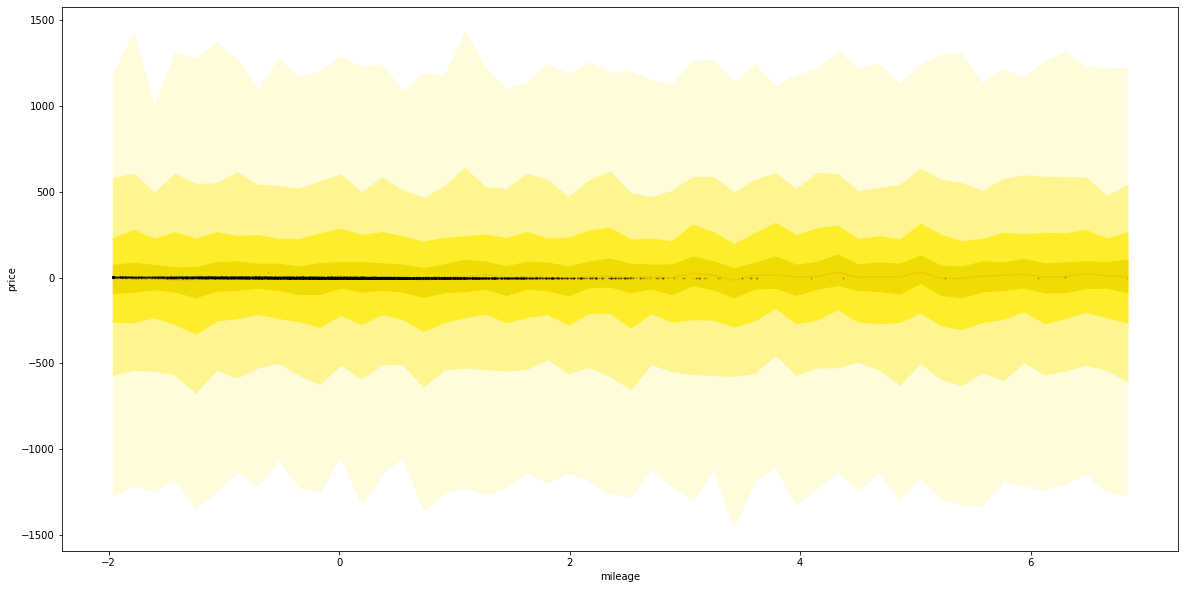

In [740]:
price_sim=sim.stan_variable('price')
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes=ribbon_plot(data_sim['mileage'] + data.s_mileage.mean(), price_sim, axes)
axes.scatter(data.s_mileage, data.s_price, color='black', alpha=0.1, s=1)
axes.set_xlabel('mileage')
axes.set_ylabel('price')
plt.show()

In [741]:
with open('cost_2_fit.stan', 'r') as file: 
    print(file.read())

data { 
    int N;
    vector[N] mileage;
    real price[N];
}

parameters {
            real alpha;
            real beta;
            real<lower=0> sigma;
}
          
transformed parameters {
            vector[N] mu = mileage*beta+alpha;
}

model {
        alpha ~ normal(0,1);
        beta ~ lognormal(0,1);
        sigma ~ exponential(0.001);
        price ~ normal(mu,sigma);
}

generated quantities {
                    real prices[N];
                    real log_lik[N];
                    for (i in 1:N) {
                      prices[i] = normal_rng(mu[i],sigma);
                      log_lik[i] = normal_lpdf(price[i] | mu[i], sigma);
                    }
}


In [742]:
model_2_fit=CmdStanModel(stan_file='cost_2_fit.stan') 
model_2_fit.compile(force=False)
d_short=data.head(1000)
data_fit=dict(N=len(d_short),
              mileage=d_short.s_mileage.values,
              price=d_short.s_price.values)
fit=model_2_fit.sample(data=data_fit,seed=28052020)
alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
price_pred=fit.stan_variable('prices')
log_lik=fit.stan_variable('log_lik')
az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit.stan to exe file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit.hpp /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit.stan
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/cost_2_fit.stan', line 25, column 20: Declaration
    of arrays by plac

chain 4 |██████████████████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 2 |██████████████████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |█████████████████████████████████████████████| 00:03 Sampling completed
chain 2 |█████████████████████████████████████████████| 00:03 Sampling completed
chain 3 |█████████████████████████████████████████████| 00:03 Sampling completed
chain 4 |█████████████████████████████████████████████| 00:03 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%
alpha,-0.58,0.01,-0.60,-0.55
beta,0.01,0.00,0.00,0.01
sigma,0.48,0.01,0.46,0.50


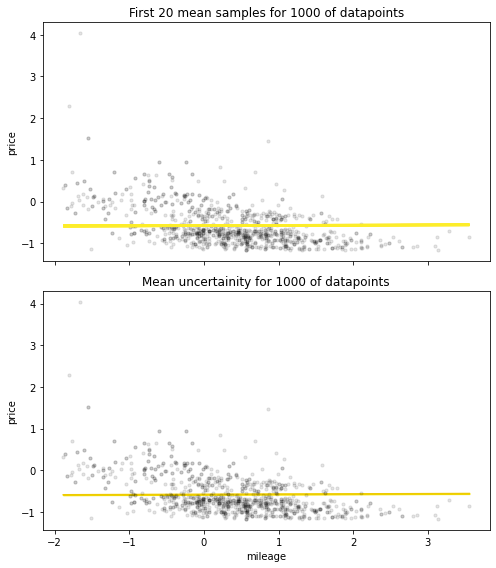

In [743]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True) 
ax0=axes[0]
for i in range(100):
    ax0.plot(d_short.s_mileage,
              alpha_fit[i]+beta_fit[i]*d_short.s_mileage,
                color=MID,
                alpha=0.5,linewidth=0.5) 
ax0.scatter(d_short.s_mileage,d_short.s_price,color='black',alpha=0.1,s=10) 
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short))) 
ax0.set_ylabel('price')
ax1=axes[1]
ax1=ribbon_plot(d_short.s_mileage.values,mu_fit,ax1,supress_warning=True) 
ax1.scatter(d_short.s_mileage,d_short.s_price,color='black',alpha=0.1,s=10) 
ax1.set_xlabel('mileage')
ax1.set_ylabel('price')
ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short))) 
fig.tight_layout()
plt.show()

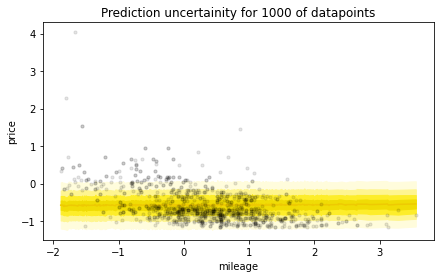

In [744]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.s_mileage.values,price_pred,axes,supress_warning=True) 
axes.scatter(d_short.s_mileage,d_short.s_price,color='black',alpha=0.1,s=10) 
axes.set_xlabel('mileage')
axes.set_ylabel('price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

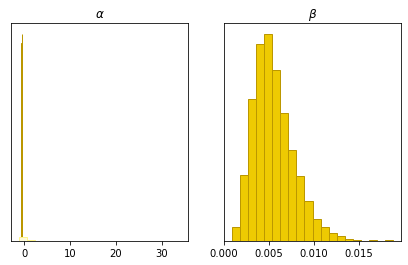

In [745]:
ig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax = axes[0] 
ax.hist(alpha_fit,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax.hist(data.s_price,bins=20,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True) 
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1] 
ax2.hist(beta_fit,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

Adding second predictor - BMI

In [746]:
# centering variables
data['s_vol_engine2'] = data.s_vol_engine*data.s_vol_engine
data['s_vol_engine3'] = data.s_vol_engine*data.s_vol_engine*data.s_vol_engine


data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,...,s_mileage,c_vol_engine,s_vol_engine,c_year,s_year,s_price,c_vol_engine2,c_vol_engine3,s_vol_engine2,s_vol_engine3
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,...,-0.190338,-351.194141,-1.074924,3.331711,0.644302,0.027795,123337.324916,-4.331535e+07,1.155461,-1.242033e+00
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,...,-1.557194,-100.194141,-0.306671,6.331711,1.224457,1.525978,10038.865960,-1.005836e+06,0.094047,-2.884154e-02
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,...,1.574111,-1.194141,-0.003655,3.331711,0.644302,-0.285198,1.425974,-1.702814e+00,0.000013,-4.882684e-08
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,...,-1.358869,-351.194141,-1.074924,4.331711,0.837687,-0.151561,123337.324916,-4.331535e+07,1.155461,-1.242033e+00
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,...,-0.654965,-199.194141,-0.609687,2.331711,0.450917,0.027795,39678.305947,-7.903686e+06,0.371718,-2.266319e-01
5,5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Warszawa,Mazowieckie,...,-0.423680,-1.194141,-0.003655,5.331711,1.031072,0.590480,1.425974,-1.702814e+00,0.000013,-4.882684e-08
6,6,opel,combo,gen-d-2011,2017,119965,1248,Diesel,Wrocław,Dolnośląskie,...,-0.439410,-351.194141,-1.074924,5.331711,1.031072,0.337272,123337.324916,-4.331535e+07,1.155461,-1.242033e+00
7,7,opel,combo,gen-d-2011,2016,201658,1248,Diesel,Lublin,Lubelskie,...,0.598568,-351.194141,-1.074924,4.331711,0.837687,-0.214863,123337.324916,-4.331535e+07,1.155461,-1.242033e+00
8,8,opel,combo,gen-d-2011,2014,178666,1598,Diesel,Złotów,Wielkopolskie,...,0.306436,-1.194141,-0.003655,2.331711,0.450917,-0.218380,1.425974,-1.702814e+00,0.000013,-4.882684e-08
9,9,opel,combo,gen-d-2011,2015,113000,1248,Diesel,Strzyżew,Mazowieckie,...,-0.527906,-351.194141,-1.074924,3.331711,0.644302,-0.007373,123337.324916,-4.331535e+07,1.155461,-1.242033e+00


In [748]:
with open('cost_3_fit.stan', 'r') as file: 
    print(file.read())

data { int N;
  vector[N] mileage;
  vector[N] vol_engine;
  real price[N];
}

parameters {
  real alpha;
  real beta_mileage;
  real beta_vol_engine;
  real beta_vol_engine2;
  real beta_vol_engine3;


  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = mileage*beta_mileage+vol_engine*beta_vol_engine+(vol_engine^2)*beta_vol_engine2+ +(vol_engine^3)*beta_vol_engine3 +alpha;
}

model {
  alpha ~ normal(0,1);
  beta_mileage ~ lognormal(0,1);
  beta_vol_engine ~ lognormal(0, 10);
  sigma ~ exponential(0.001);
  price ~ normal(mu,sigma);
}

generated quantities {
  real prices[N];
  real log_lik[N];
  for (i in 1:N) {
    prices[i] = normal_rng(mu[i],sigma);
    log_lik[i] = normal_lpdf(price[i] | mu[i], sigma);
  }
}


In [757]:
model_3_fit=CmdStanModel(stan_file='cost_3_fit.stan') 
model_3_fit.compile(force=False)
d_short=data.head(1000)
data_fit=dict(N=len(d_short),
              mileage=d_short.s_mileage.values,
              vol_engine=d_short.s_vol_engine.values,
              price=d_short.s_price.values)

fit_2 = model_3_fit.sample(data=data_fit,seed=28052020)
alpha_fit = fit_2.stan_variable('alpha')
beta_mileage_fit = fit_2.stan_variable('beta_mileage')
beta_vol_engine_fit = fit_2.stan_variable('beta_vol_engine')
beta_vol_engine_fit2 = fit_2.stan_variable('beta_vol_engine2')
beta_vol_engine_fit3 = fit_2.stan_variable('beta_vol_engine3')


mu_fit_2 = fit_2.stan_variable('mu')
price_pred_2 = fit_2.stan_variable('prices')
log_lik = fit_2.stan_variable('log_lik')
az.summary(fit_2,var_names=['alpha','beta_mileage','beta_vol_engine','sigma'],round_to=2,kind='stats')
# Values are standarized so we can see that Age variable is much more important by looking at mean for both betas in
#summary below

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status

chain 1 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |███▎                    | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███▎                    | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███▎                    | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████▎                   |


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%
alpha,-0.66,0.02,-0.69,-0.64
beta_mileage,0.01,0.00,0.00,0.01
beta_vol_engine,0.00,0.00,0.00,0.00
sigma,0.45,0.01,0.44,0.46


In [758]:
log_lik

array([[ -0.941273, -11.0313  ,  -0.51356 , ...,  -0.177051,  -0.179736,
         -0.17618 ],
       [ -0.939392, -11.0295  ,  -0.513065, ...,  -0.176984,  -0.179733,
         -0.176065],
       [ -0.939247, -11.0291  ,  -0.51301 , ...,  -0.176994,  -0.179747,
         -0.17607 ],
       ...,
       [ -0.960882, -12.0723  ,  -0.466422, ...,  -0.120549,  -0.123968,
         -0.116138],
       [ -0.960025, -12.0346  ,  -0.464536, ...,  -0.121999,  -0.125357,
         -0.117405],
       [ -0.963116, -12.0833  ,  -0.465833, ...,  -0.12016 ,  -0.123505,
         -0.11572 ]])

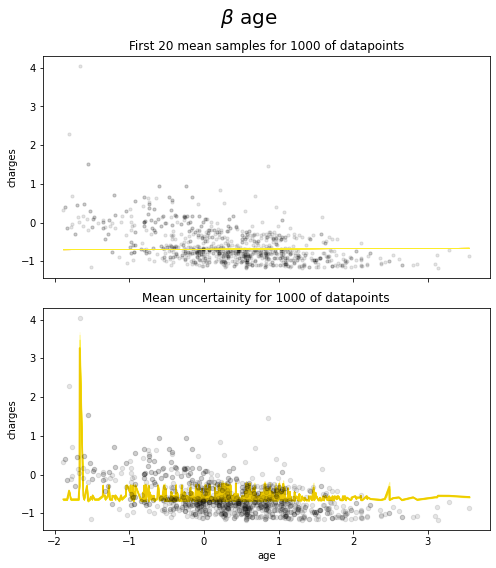

In [759]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True) 
ax0=axes[0]
for i in range(20):
    ax0.plot(d_short.s_mileage,
              alpha_fit[i]+beta_mileage_fit[i]*d_short.s_mileage,
              color=MID,
              alpha=0.5,linewidth=0.5)
ax0.scatter(d_short.s_mileage,d_short.s_price,color='black',alpha=0.1,s=10) 
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short))) 
fig.suptitle(r'$\beta$ age', fontsize=20)
ax0.set_ylabel('charges')
ax1=axes[1] 
ax1=ribbon_plot(d_short.s_mileage.values,mu_fit_2,ax1,supress_warning=True) 
ax1.scatter(d_short.s_mileage,d_short.s_price,color='black',alpha=0.1,s=20) 
ax1.set_xlabel('age')
ax1.set_ylabel('charges')
ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short))) 
fig.tight_layout()
plt.show()

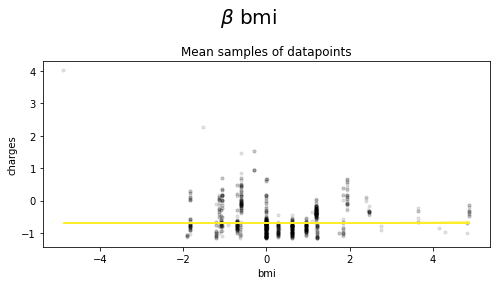

In [760]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True) 
for i in range(459):
    axes.plot(d_short.s_vol_engine,
              alpha_fit[i]+beta_vol_engine_fit[i]*d_short.s_vol_engine,
              color=MID,
              alpha=0.5,linewidth=0.5)
axes.scatter(d_short.s_vol_engine,d_short.s_price,color='black',alpha=0.1,s=10)
axes.set_title('Mean samples of datapoints'.format(len(d_short)))
fig.suptitle(r'$\beta$ bmi', fontsize=20)
axes.set_ylabel('charges')
axes.set_xlabel('bmi')
fig.tight_layout()
plt.show()
# beta for BMI parameter is very close to 0 and insignificant

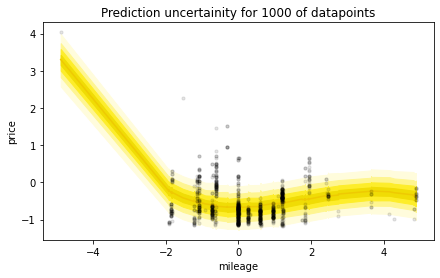

In [761]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.s_vol_engine.values,price_pred_2,axes,supress_warning=True) 
axes.scatter(d_short.s_vol_engine,d_short.s_price,color='black',alpha=0.1,s=10) 
axes.set_xlabel('mileage')
axes.set_ylabel('price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

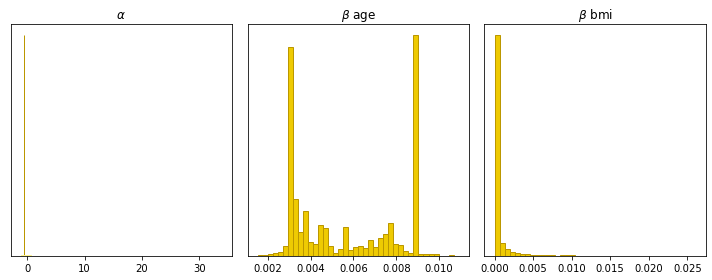

In [762]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax = axes[0] 
ax.hist(alpha_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax.hist(data.s_price,bins=40,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True) 
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1] 
ax2.hist(beta_mileage_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$ age')
ax2.set_yticks(())
fig.tight_layout()
ax2 = axes[2] 
ax2.hist(beta_vol_engine_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$ bmi')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

Comparing models

In [766]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = fit, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = fit_2, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "loo") # loo stands for leave one out cross validation

/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-621.087877,3.684125,0.000000,0.794552,35.052091,0.000000,True,log
model_1,1,-684.923495,8.284548,63.835618,0.205448,58.359184,47.947544,True,log


In [767]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = fit, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = fit_2, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-621.231257,3.827504,0.000000,0.794378,35.056214,0.000000,True,log
model_1,1,-684.055640,7.416693,62.824383,0.205622,57.646175,46.970426,True,log


/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot:xlabel='Log'>

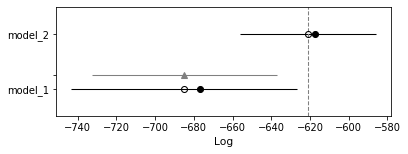

In [765]:
az.plot_compare(az.compare(compare_dict))
